**Einlesen der Daten**

In [20]:
import pandas as pd

df = pd.read_csv("trainingsdaten_ohne_vibration.csv", encoding = "ISO-8859-1")
df_test = pd.read_csv("testdaten_mit_vibration.csv", encoding = "ISO-8859-1")

**Trainingsdaten anschauen**

In [21]:
df.head()

,Time,AmplitudeBandWidth,AmplitudeMean,NumberOverload,NumberUnderloads,StabilizationTime
0,2018-04-11 18:19:38,7.417,2.098,0,0,3214
1,2018-04-11 18:19:46,0.726,0.402,0,0,3339
2,2018-04-11 18:19:57,6.061,2.092,0,0,3167
3,2018-04-11 18:20:10,0.716,0.298,0,0,3261
4,2018-04-11 18:20:14,0.638,0.578,0,0,3011


**Testdaten anschauen**

In [22]:
df_test.head()

,Time,AmplitudeBandWidth,AmplitudeMean,NumberOverload,NumberUnderloads,StabilizationTime,VibrationMotorOn
0,Thu Apr 12 2018 08:51:52 GMT+0200 (Mitteleurop...,36.285,12.502,0,0,3230,True
1,Thu Apr 12 2018 08:52:07 GMT+0200 (Mitteleurop...,71.899,24.918,0,0,3199,True
2,Thu Apr 12 2018 08:52:20 GMT+0200 (Mitteleurop...,543.236,474.136,0,0,4041,True
3,Thu Apr 12 2018 08:52:30 GMT+0200 (Mitteleurop...,44.625,15.188,0,0,5055,True
4,Thu Apr 12 2018 08:52:42 GMT+0200 (Mitteleurop...,34.323,11.074,0,0,3089,True


***Time* löschen**

In [23]:
del df["Time"]
del df_test["Time"]

**Deskriptive Statistik (Trainingsdaten)**

In [24]:
df.describe()

,AmplitudeBandWidth,AmplitudeMean,NumberOverload,NumberUnderloads,StabilizationTime
count,2090.000000,2090.000000,2090.0,2090.0,2090.000000
mean,1.159642,0.519354,0.0,0.0,4130.505742
std,1.760196,0.676685,0.0,0.0,773.941131
min,0.000000,0.000000,0.0,0.0,3011.000000
25%,0.320000,0.168000,0.0,0.0,3245.000000
50%,0.471000,0.254000,0.0,0.0,4462.000000
75%,0.830250,0.416000,0.0,0.0,4837.000000
max,18.418000,7.834000,0.0,0.0,6927.000000


**Deskriptive Statistik (Testdaten)**

In [25]:
df_test.describe()

,AmplitudeBandWidth,AmplitudeMean,NumberOverload,NumberUnderloads,StabilizationTime
count,187.000000,187.000000,187.0,187.0,187.000000
mean,70.186679,32.865059,0.0,0.0,4148.048128
std,123.702463,87.268628,0.0,0.0,1364.414429
min,0.061000,0.042000,0.0,0.0,2481.000000
25%,29.116000,9.063000,0.0,0.0,3050.500000
50%,38.549000,12.502000,0.0,0.0,3760.000000
75%,51.010500,17.995000,0.0,0.0,4704.000000
max,580.684000,496.094000,0.0,0.0,8815.000000


**Daten visualisieren**

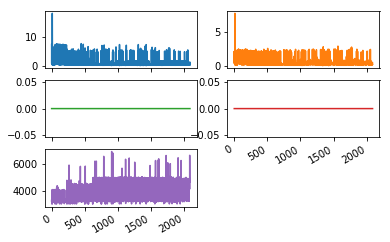

In [26]:
import matplotlib.pyplot as plt

df.plot(subplots=True, layout=(3,2), legend=False)
plt.show()

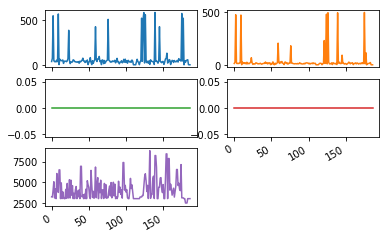

In [27]:
df_test.plot(subplots=True, layout=(3,2), legend=False)
plt.show()

**Datenvorverarbeitung**

In [28]:
# 2 Spalten enthalten keine Information -> löschen
df = df.drop(['NumberOverload', 'NumberUnderloads'], 1)
df_test = df_test.drop(['NumberOverload', 'NumberUnderloads'], 1)

**Test- und Trainingsdaten festlegen**

In [29]:
X_train = df
X_test = df_test[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].copy()
y_test = df_test[['VibrationMotorOn']].copy()

**Modell trainieren**

In [30]:
from sklearn.ensemble import IsolationForest

# Modell fitten
clf = IsolationForest(random_state=42)
clf.fit(X_train)

new_column = pd.DataFrame(columns = ["Anomaly"])
# Vorhersage des Modells
for k in range(len(X_test)):
    temp = clf.predict([[X_test["AmplitudeBandWidth"][k], X_test["AmplitudeMean"][k], X_test["StabilizationTime"][k]]])[0]
    new_column = new_column.append({"Anomaly": temp}, ignore_index = True)

# Vorhersage des Modells auf 1/0 recodieren
new_column['Anomaly'] = new_column['Anomaly'].map( {1: 0, -1: 1} )

**Metriken ausgeben**

In [40]:
from sklearn import metrics

print ("Accuracy: ")
print (metrics.accuracy_score(y_test, new_column))
print ("Classification Report:")
print (metrics.classification_report(y_test, new_column))
print ("Confusion Matrix:")
print (metrics.confusion_matrix(y_test, new_column))  

Accuracy: 
0.9732620320855615
Classification Report:
             precision    recall  f1-score   support

      False       0.78      0.70      0.74        10
       True       0.98      0.99      0.99       177

avg / total       0.97      0.97      0.97       187

Confusion Matrix:
[[  7   3]
 [  2 175]]


**Daten zusammenführen für Visualisierung**

In [32]:
complete_data = X_test.copy()
complete_data['VibrationMotorOn'] = y_test['VibrationMotorOn']
complete_data['Anomaly'] = new_column.values

**Farben für Visualisierung einfügen**

In [33]:
complete_data["color"] = 0
for idx,row in complete_data.iterrows():
    label_true = complete_data.loc[idx,"VibrationMotorOn"]
    label_pred = complete_data.loc[idx,"Anomaly"]
    if  label_true == True:
        if  label_pred == True:
            complete_data.loc[idx,"color"] = "blue"
        else:
            complete_data.loc[idx,"color"] = "green"
    else:
        if label_pred == False:
            complete_data.loc[idx,"color"] = "red"            
        else:
            complete_data.loc[idx,"color"] = "yellow"

**Visualisierung der Konfusionsmatrix**

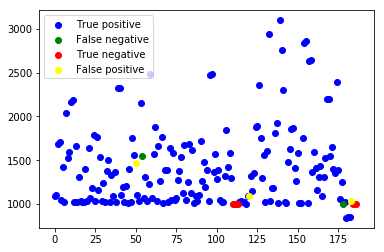

In [41]:
fig, ax = plt.subplots()
a = complete_data.copy()

ax.scatter(a.loc[a.color == 'blue'].index,a.loc[a.color == 'blue',['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].mean(axis=1), color='blue', label='True positive')
ax.scatter(a.loc[a.color == 'green'].index,a.loc[a.color == 'green',['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].mean(axis=1), color='green', label='False negative')
ax.scatter(a.loc[a.color == 'red'].index,a.loc[a.color == 'red',['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].mean(axis=1), color='red', label='True negative')
ax.scatter(a.loc[a.color == 'yellow'].index,a.loc[a.color == 'yellow',['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].mean(axis=1), color='yellow', label='False positive')

plt.legend()
plt.show()